This notebook clips 1/10th-acre plots from 1 hectuare clips that have been made from lidar data served by the Washington Department of Natural Resources. These data were provided by Guy McWethy. There are other lidar acquisitions that will also be considered which DNR does not serve, but those are not addressed here. Similarly, this notebook does not deal with any forest inventory plots other than those measured by WA DNR.

In [29]:
import geopandas as gpd
import pandas as pd
import glob
import os
import subprocess
import dask
from dask.distributed import Client, LocalCluster, progress
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
ha_plots = gpd.read_file('../data/processed/blm_usfs_wadnr_plots_1ha.shp')
dnr_plots = ha_plots.loc[ha_plots.source == 'WA-DNR']
dnr_plots.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2487 entries, 2602 to 5088
Data columns (total 10 columns):
comments     0 non-null object
lat          2487 non-null float64
lon          2487 non-null float64
meas_date    2487 non-null object
orig_id      2487 non-null object
plot_id      2487 non-null object
source       2487 non-null object
meas_yr      2487 non-null int64
uuid         2487 non-null object
geometry     2487 non-null object
dtypes: float64(2), int64(1), object(7)
memory usage: 213.7+ KB


In [3]:
dnr_plots.crs

{'init': 'epsg:4326'}

In [15]:
sp_plots = dnr_plots.to_crs({'init': 'epsg:2927'})
sp_plots['x'] = sp_plots.centroid.x
sp_plots['y'] = sp_plots.centroid.y
sp_plots = sp_plots[['uuid', 'x', 'y']].set_index('uuid')

In [5]:
HA_CLIPS = '../data/raw/lidar/dnr_portal/dnrplot_clips/hectare_clips_epsg2927/*.laz'
ha_plot_clips = glob.glob(HA_CLIPS)
ha_plot_clips[0]

'../data/raw/lidar/dnr_portal/dnrplot_clips/hectare_clips_epsg2927/0083eb5e-aed6-4c22-9412-bc116d072ed9_ahtanum-2006.laz'

In [6]:
dnr_plot_clips = [p for p in ha_plot_clips if 
                  os.path.basename(p).split('_')[0] in dnr_plots.uuid.values]

In [7]:
len(dnr_plot_clips)

2735

In [8]:
dnr_plot_clips[0]

'../data/raw/lidar/dnr_portal/dnrplot_clips/hectare_clips_epsg2927/0083eb5e-aed6-4c22-9412-bc116d072ed9_ahtanum-2006.laz'

In [9]:
sp_plots.head()

,comments,lat,lon,meas_date,orig_id,plot_id,source,meas_yr,uuid,geometry,x,y
2602,None,45.741098,-122.354746,2014-07-01,a4879c7d-86eb-4b9f-a910-3840cecded33,a4879c7d-86eb-4b9f-a910-3840cecded33,WA-DNR,2014,a4879c7d-86eb-4b9f-a910-3840cecded33,"POLYGON ((1167105.510143428 154272.714178029, ...",1166883.3,154266.9
2603,None,46.971436,-123.153256,2013-12-19,7b78b711-ba71-447f-8d77-4b35f0c8c3c0,7b78b711-ba71-447f-8d77-4b35f0c8c3c0,WA-DNR,2013,7b78b711-ba71-447f-8d77-4b35f0c8c3c0,"POLYGON ((978393.410143432 608512.5141780027, ...",978171.2,608506.7
2604,None,46.512896,-121.025579,2013-06-11,5f915933-fc79-40aa-acc1-f852029f4d69,5f915933-fc79-40aa-acc1-f852029f4d69,WA-DNR,2013,5f915933-fc79-40aa-acc1-f852029f4d69,"POLYGON ((1508317.710143427 430590.0141782704,...",1508095.5,430584.2
2605,None,46.460500,-122.033348,2014-03-20,fa818ffa-a433-452b-8561-cb4d266a431f,fa818ffa-a433-452b-8561-cb4d266a431f,WA-DNR,2014,fa818ffa-a433-452b-8561-cb4d266a431f,"POLYGON ((1254249.210143431 414797.6141780733,...",1254027.0,414791.8
2606,None,46.476230,-122.002239,2014-03-20,7b6023d4-5349-4e23-aa53-63897d642292,7b6023d4-5349-4e23-aa53-63897d642292,WA-DNR,2014,7b6023d4-5349-4e23-aa53-63897d642292,"POLYGON ((1262196.710143433 420382.0141780211,...",1261974.5,420376.2


In [19]:
@dask.delayed
def clip_smaller_plot(infile):
    basename = os.path.basename(infile)
    ODIR = '../data/raw/lidar/dnr_portal/dnrplot_clips/plot_clips_epsg2927/'
    outfile = os.path.join(ODIR, basename)
    plot_id = basename.split('_')[0]
    match = sp_plots.loc[plot_id][['x', 'y']]
    x, y = match.x, match.y
    
    proc = subprocess.run(['wine', '/storage/lidar/LAStools/bin/las2las.exe',
                           '-i', infile,
                           '-o', outfile,
                           # radius of 1/10th-acre plot in feet
                           '-keep_circle', str(x), str(y), '37.2'], 
                          stderr=subprocess.PIPE,
                          stdout=subprocess.PIPE)
#     print(outfile)
    return proc

In [41]:
@dask.delayed
def get_boundary(infile, odir):
    proc = subprocess.run(['wine', '/storage/lidar/LAStools/bin/lasboundary.exe',
                           '-i', infile,
                           '-odir', odir,
                           '-oshp',
                           '-labels'], 
                          stderr=subprocess.PIPE,
                          stdout=subprocess.PIPE)
#     print(outfile)
    return proc

In [13]:
cluster=LocalCluster(scheduler_port=7001, diagnostics_port=7002)
c = Client(cluster)

In [20]:
odir = '../data/raw/lidar/dnr_portal/dnrplot_clips/plot_clips_epsg2927_coverage/'
res = c.persist([clip_smaller_plot(p, odir=odir) for p in dnr_plot_clips])
progress(res)

VBox()

In [37]:
ODIR = '../data/raw/lidar/dnr_portal/dnrplot_clips/plot_clips_epsg2927/'
PLOT_CLIPS = os.path.join(ODIR, '*.laz')
clipped = glob.glob(PLOT_CLIPS)
len(clipped)

2735

In [23]:
res = c.persist([get_boundary(p, odir=ODIR) for p in clipped])
progress(res)

VBox()

In [40]:
HA_ODIR = '../data/raw/lidar/dnr_portal/dnrplot_clips/hectare_clips_epsg2927/'
HA_PLOT_CLIPS = os.path.join(HA_ODIR, '*.laz')
ha_clipped = glob.glob(HA_PLOT_CLIPS)
len(ha_clipped)

2735

In [42]:
res = c.persist([get_boundary(p, odir=HA_ODIR) for p in ha_clipped])
progress(res)

VBox()

In [57]:
# c.close()
# cluster.close()

In [24]:
# inspect coverages
SHPS = '../data/raw/lidar/dnr_portal/dnrplot_clips/plot_clips_epsg2927_coverage/*.shp'
shps = glob.glob(SHPS)
len(shps)

2735

In [49]:
# inspect coverages
HA_SHPS = '../data/raw/lidar/dnr_portal/dnrplot_clips/hectare_clips_epsg2927/*.shp'
ha_shps = glob.glob(HA_SHPS)
len(ha_shps)

2735

In [25]:
# read in all the shapefiles of clipped plot boundaries into a list
gdfs = [gpd.read_file(shp) for shp in shps]
# concatentate them into a single geodataframe
gdf = pd.concat(gdfs, axis=0, ignore_index=True)
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2735 entries, 0 to 2734
Data columns (total 12 columns):
file_name     2735 non-null object
version       2735 non-null object
num_points    2735 non-null int64
point_type    2735 non-null int64
point_size    2735 non-null int64
min_x         2735 non-null float64
max_x         2735 non-null float64
min_y         2735 non-null float64
max_y         2735 non-null float64
min_z         2735 non-null float64
max_z         2735 non-null float64
geometry      2735 non-null object
dtypes: float64(6), int64(3), object(3)
memory usage: 256.5+ KB


In [50]:
# read in all the shapefiles of clipped plot boundaries into a list
ha_gdfs = [gpd.read_file(shp) for shp in ha_shps]
# concatentate them into a single geodataframe
ha_gdf = pd.concat(ha_gdfs, axis=0, ignore_index=True)
ha_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2735 entries, 0 to 2734
Data columns (total 12 columns):
file_name     2735 non-null object
version       2735 non-null object
num_points    2735 non-null int64
point_type    2735 non-null int64
point_size    2735 non-null int64
min_x         2735 non-null float64
max_x         2735 non-null float64
min_y         2735 non-null float64
max_y         2735 non-null float64
min_z         2735 non-null float64
max_z         2735 non-null float64
geometry      2735 non-null object
dtypes: float64(6), int64(3), object(3)
memory usage: 256.5+ KB


In [26]:
gdf.crs

{'init': 'epsg:2927'}

In [54]:
gdf['acres'] = gdf.area / 43560  # sq ft per acre
ha_gdf['acres'] = ha_gdf.area / 43560

In [28]:
gdf.acres.head()

0    0.099091
1    0.098656
2    0.097294
3    0.098573
4    0.099199
Name: acres, dtype: float64

In [55]:
ha_gdf.acres.head()

0    2.464116
1    2.455857
2    2.469404
3    2.464307
4    2.469219
Name: acres, dtype: float64

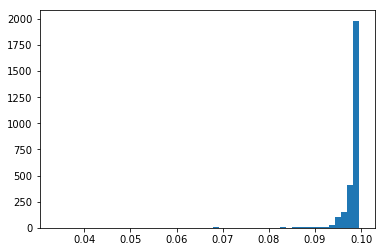

In [32]:
plt.hist(gdf.acres, bins=50);

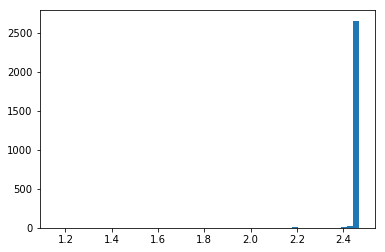

In [56]:
plt.hist(ha_gdf.acres, bins=50);